# NLP2 project A: on measuring bias

**TA: Oskar van der Wal**

*Some parts of this tutorial and its code are based on the paper 📄 **"The Birth of Bias: A case study on the evolution of gender bias in an English language model"** ([link](https://arxiv.org/abs/2207.10245)). Other explanations are taken from [this blog post](https://odvanderwal.nl/2022/gender-bias-in-language-models.html). Quotations taken from these and other sources are indicated by a speech balloon 💬.*

**About this tutorial:**
- 📏 In this notebook, you will explore different techniques for measuring gender bias in NLP models---in static word embeddings and contextual language models.
- ⏱️ You are also provided with different training checkpoints of an LSTM language model to explore how the representation of gender bias changes over time.
- 🧑‍🤝‍🧑 The goal of this tutorial is to investigate *how* gender bias develops while a language model is learning to predict the next words. We take a dichotomous approach (*he* vs *she*) so that we can use existing tools developed in previous works. However, in reality gender bias is a much more complicated topic than we assume here. Moreover, the "debiasing" approach we use is not solving the issue and is instead used as a diagnostic tool. For actually mitigating gender bias, we also require a better understanding of the socio-technical context in which the language model is used (e.g. How is it deployed? Who might be harmed by its inproper use? ([Blodgett et al., 2020](https://aclanthology.org/2020.acl-main.485/))).
- ✅ You will also think a bit about the validity of the bias measures: *Do you believe a high bias score necessarily means that the model is more biased, or do you have reasons to be skeptical?* 
- 🔬 At the end of this tutorial (**4 Future work**) you will start thinking about your own experiment where you study the validity and reliability of a bias measure. This forms the basis of your *method* section and guides the rest of your project.

**About the assignments:**
- This NLP2 project consists of two parts: 1) the assignments in this notebook (*5% of the grade*) and 2) a 4-page report where you discuss your own experiment (*95% of the grade*). More information can be found on Canvas.
- The assignments are marked with a symbol ☑️, 📊, and 🧠 depending on the type of task. **The ones marked with an extra ✍️ (ToSubmit) have to be handed in for 5% of the grade.** The answers should be provided in a PDF document -- but check Canvas for the exact requirements. 

---
⚠️**Before starting this notebook:**⚠️
- [ ] Make sure you have downloaded [the directory](https://drive.google.com/drive/folders/1gnqanK5VuEIASd9U098Tlo9kknShDHwy?usp=sharing) `IEinAI_gender_bias/` and placed it in your Google Drive.
- [ ] This directory should contain the LSTM checkpoints in `LSTM/` and two files used for one bias measure in `data/`.
- [ ] Change the runtime to GPU (`Runtime -> Change runtime type -> Hardware Accelator -> GPU`).

In [ ]:
# Setup connection to Google Drive
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/My Drive/IEinAI_gender_bias"
!ls

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1gnqanK5VuEIASd9U098Tlo9kknShDHwy/IEinAI_gender_bias
data  LSTM


In [ ]:
!pip install allennlp
!pip install --upgrade google-cloud-storage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00


## 1 Gender Bias in Static Word Embeddings
Before studying the gender bias of a language model, you will study the bias in static word embeddings. The technique you will relies on finding a gender subspace that captures the "genderedness" of the word vectors.

See the figure and the explanation from [this blog post](https://odvanderwal.nl/2022/gender-bias-in-language-models.html) below:

💬 "For this measure, we start with a set of unambiguously female and male words (e.g. "man"-"woman", "he"-"she", "son"-"daughter") and train a linear classifier, such as a support vector machine (SVM), to predict the gender of each word."

💬 "We then define the gender subspace as the axis orthogonal to the decision boundary of the linear SVM that is trained to predict the gender for a set of male and female words.

💬 "Now we can use the gender subspace for quantifying the gender bias of, for example, occupation terms. For finding the bias score of a word in the embedding space, we use the scalar projection on the gender subspace. In the example below, words like "engineer" and "scientist" are on the "male" side of the subspace (to the left of the purple decision boundary), while "nurse" and "receptionist" have a female bias (to the right). The farther away from the decision boundary the word is, the higher the bias."

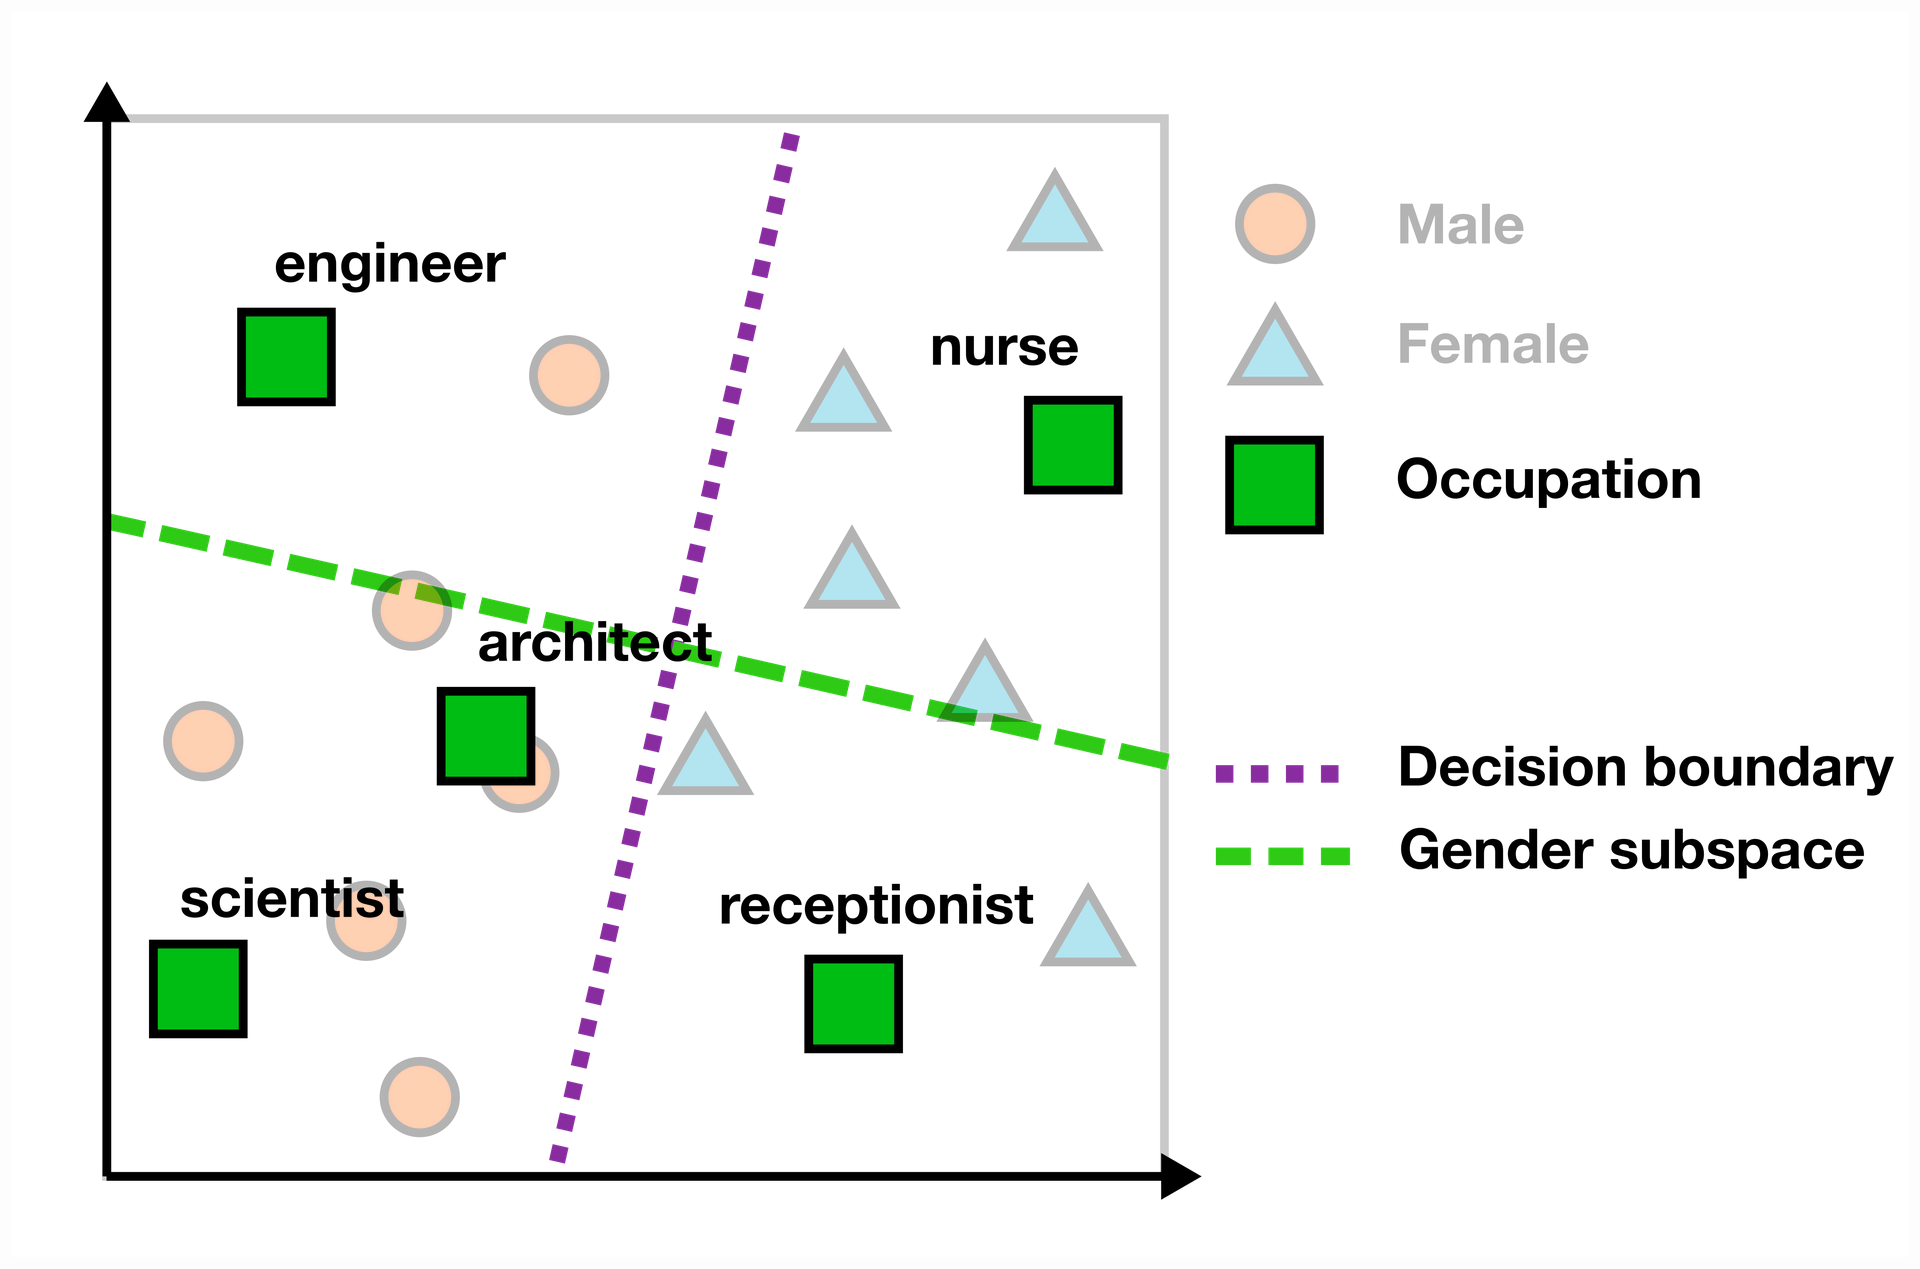

### Simple GloVe Embeddings
Let's download a simple pretrained GloVe embedding model and see if you can find any evidence of gender bias using the above technique.

In [ ]:
import gensim
import gensim.downloader

class StaticEmbedding:
  def __init__(self, model_fp=None):
    if model_fp:
      self.model = gensim.models.KeyedVectors.load_word2vec_format(
              model_fp, binary=True
          )
    else:
      self.model = gensim.downloader.load('glove-twitter-25')
  
  def __call__(self, word):
    return self.model[word]

glove = StaticEmbedding()

In [ ]:
glove("man")

array([ 0.37013 , -0.39648 , -0.021712, -0.6301  , -0.3189  ,  0.34329 ,
        0.10968 ,  0.4879  , -0.48663 ,  0.36837 , -0.39179 ,  0.25414 ,
       -4.9282  ,  0.067597,  0.37147 ,  0.36817 ,  1.1655  ,  0.092116,
       -0.87735 , -0.74562 ,  0.40903 ,  1.5672  , -0.23879 ,  0.24755 ,
        0.76386 ], dtype=float32)

First, we need to define a list of word pairs that we can use for finding the **gender subspace**.

In [ ]:
pairs = [('man', 'woman'),
 ('boy', 'girl'),
 ('male', 'female'),
 ('he', 'she'),
 ('himself', 'herself'),
 ('his', 'her'),
 ('father', 'mother'),
 ('son', 'daughter')]

#### ☑️ 1.1 ToDo

Now use a linear SVM from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to implement the function `get_gender_subspace` that finds the gender subspace $\vec{g}$ given the word pairs.

In [ ]:
from sklearn.svm import SVC
import numpy as np

def wordlist2matrix(wordlist, model):
    """Helper function for converting a wordlist to a matrix 
    using the (GloVe) model"""
    return np.stack([model(x) for x in wordlist])

def get_gender_subspace(pairs, model):
    # clf is the SVM that has been fit on X and Y
    word_list = [x[0] for x in pairs] + [x[1] for x in pairs]
    X = wordlist2matrix(word_list, glove)
    y = np.repeat([1, 0], 8)
    # X = wordlist2matrix(pairs, glove).reshape(16,25)
    # y = np.tile([1, 0], 8)
    clf = SVC(kernel='linear')
    clf.fit(X,y)
    return clf.coef_[0]

g = get_gender_subspace(pairs, glove)

💬 "Given this subspace $\vec{g}$, gender bias (w.r.t. the gender-neutral norm) can be defined using the scalar projection of every input embedding, $\vec{w}$, onto the subspace."

$$ \text{bias}_\text{IE}(w) = ⟨\vec{g}, \vec{w}⟩ $$

💬 "The resulting scalar value quantifies the strength
of the bias, while the sign indicates the direction
on the female-to-male axis." (Van der Wal et al., 2022)

#### ☑️ 1.2 ToDo
Given the gender subspace $\vec{g}$ and the word vector $\vec{w}$, implement the bias score in the function below (using one line of code). You can use, for example, `numpy`.

In [ ]:
def get_bias_score(w, g):
    """Get bias score using word vector w and bias direction b."""
    return np.dot(g,w)

In [ ]:
for word in ["he", "father", "engineer", "she", "mother", "nurse"]:
    print(word, get_bias_score(glove(word), g))

he 0.8332066216828914
father -1.7681016051585123
engineer -0.47281064641681114
she -3.101965278445667
mother -2.9708733488011196
nurse -3.212372206164094


To study the gender bias, we will use a list of occupation words that are ideally not gendered.

In [ ]:
word_list = ['technician',
 'accountant',
 'supervisor',
 'engineer',
 'worker',
 'educator',
 'clerk',
 'counselor',
 'inspector',
 'mechanic',
 'manager',
 'therapist',
 'administrator',
 'receptionist',
 'librarian',
 'advisor',
 'pharmacist',
 'janitor',
 'psychologist',
 'physician',
 'carpenter',
 'nurse',
 'investigator',
 'bartender',
 'specialist',
 'electrician',
 'officer',
 'pathologist',
 'teacher',
 'lawyer',
 'planner',
 'practitioner',
 'plumber',
 'instructor',
 'surgeon',
 'veterinarian',
 'paramedic',
 'examiner',
 'chemist',
 'machinist',
 'architect',
 'hairdresser',
 'baker',
 'programmer',
 'scientist',
 'dispatcher',
 'cashier',
 'auditor',
 'painter',
 'broker',
 'chef',
 'doctor',
 'firefighter',
 'secretary']

We now have all the ingredients for measuring the gender bias of occupation terms in the static GloVe word vectors, by scoring each individual term using the gender subspace.

In [ ]:
import pandas as pd
from itertools import chain

bias_df_occupations_static = pd.DataFrame(columns=["word", "score", "type"])

for w in word_list+list(chain.from_iterable(pairs)):
  bias_score = get_bias_score(glove(w), g)
  bias_df_occupations_static = bias_df_occupations_static.append(
                {
                    "word": w,
                    "score": bias_score,
                    "type": "occupation" if w in word_list else "gendered",
                },
                ignore_index=True,
            )
bias_df_occupations_static[bias_df_occupations_static["type"]=="gendered"].sort_values("score")

<ipython-input-11-1d82b4a88b47>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df_occupations_static = bias_df_occupations_static.append(
<ipython-input-11-1d82b4a88b47>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df_occupations_static = bias_df_occupations_static.append(
<ipython-input-11-1d82b4a88b47>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df_occupations_static = bias_df_occupations_static.append(
<ipython-input-11-1d82b4a88b47>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df_occupations_static = bias_df_occupations_static.append(
<ipython-input-11-1d82b4a88b47>:8: FutureWarning: The frame.appe

,word,score,type
65,her,-3.761151,gendered
57,girl,-3.295168,gendered
59,female,-3.102176,gendered
69,daughter,-3.102117,gendered
61,she,-3.101965,gendered
55,woman,-3.101324,gendered
63,herself,-3.101317,gendered
67,mother,-2.970873,gendered
66,father,-1.768102,gendered
64,his,-1.102215,gendered


In [ ]:
bias_df_occupations_static[bias_df_occupations_static["type"]=="occupation"].sort_values("score")

,word,score,type
16,pharmacist,-3.716126,occupation
14,librarian,-3.483110,occupation
35,veterinarian,-3.448346,occupation
11,therapist,-3.293797,occupation
21,nurse,-3.212372,occupation
46,cashier,-3.198330,occupation
4,worker,-3.167563,occupation
41,hairdresser,-3.145797,occupation
13,receptionist,-3.003564,occupation
7,counselor,-2.997267,occupation


#### 🧠 1.3 ToThink ✍️
Play around with the list of gendered word pairs (e.g. "man" vs "woman") and see how changing it influences the bias scores. Does the choice of the wordlist matter? What could be a reason for this? And does that have consequences for the validity of the bias measure?

✍️ **ToSubmit 1**

A table with two word lists and the resulting very different average absolute bias scores (as an aggregation). Explain in the caption (max 1/5 of a page) why intuitively both word lists capture the same property (gender) but don't, what the reason for this could be, and what this tells you abou the validity of the bias measure.

In [ ]:
gendered_word_pairs1 = [
    ("actor", "actress"),
    ("waiter", "waitress"),
    ("hero", "heroine"),
    ("steward", "stewardess"),
    ("host", "hostess"),
    ("boy", "girl"),
    ("cowboy", "cowgirl"),
    ("monk", "nun")
]

gendered_word_pairs2 = [
    ("doctor", "nurse"),
    ("engineer", "secretary"),
    ("ceo", "receptionist"),
    ("manager", "assistant"),
    ("pilot", "stewardess"),
    ("professor", "teacher"),
    ("lawyer", "paralegal"),
    ("accountant", "bookkeeper")
]

In [ ]:
g1 = get_gender_subspace(gendered_word_pairs1, glove)
g2 = get_gender_subspace(gendered_word_pairs2, glove)

In [ ]:
def generate_gender_score(clf, occupations):
  bias_df_occupations_static = pd.DataFrame(columns=["word", "score", "type"])

  for w in word_list+list(chain.from_iterable(occupations)):
    bias_score = get_bias_score(glove(w), clf)
    bias_df_occupations_static = bias_df_occupations_static.append(
                  {
                      "word": w,
                      "score": bias_score,
                      "type": "occupation" if w in word_list else "gendered",
                  },
                  ignore_index=True,
              )
  return bias_df_occupations_static[bias_df_occupations_static["type"]=="occupation"].sort_values("score")
   

In [ ]:
import warnings
warnings.filterwarnings("ignore")
generate_gender_score(g1, word_list)

,word,score,type
5,educator,-3.333099,occupation
27,pathologist,-3.275014,occupation
4,worker,-2.546390,occupation
7,counselor,-2.334824,occupation
45,dispatcher,-2.202747,occupation
36,paramedic,-2.197977,occupation
14,librarian,-2.163930,occupation
1,accountant,-2.155869,occupation
30,planner,-2.112970,occupation
11,therapist,-1.982543,occupation


In [ ]:
generate_gender_score(g2, word_list)

,word,score,type
41,hairdresser,-3.221286,occupation
11,therapist,-2.827015,occupation
35,veterinarian,-2.622377,occupation
21,nurse,-2.582553,occupation
14,librarian,-2.498537,occupation
13,receptionist,-2.455524,occupation
31,practitioner,-2.215434,occupation
7,counselor,-2.148667,occupation
46,cashier,-1.996386,occupation
30,planner,-1.996037,occupation


### Different language or bias type

#### 📊 1.4 ToShow ✍️
Now it is time for you to apply the technique to a new use-case. Choose one of the following assignments:
1. Come up with your own bias dimension (e.g. gender, race, religion) that you are interested in. Create a new word list and see if you can find any evidence of bias. You can use the GloVe model we used above, or swap the model for something like `"word2vec-google-news-300"`.
2. Explore the gender bias of a static word embedding for a different language (check [these FastText embeddings](https://fasttext.cc/docs/en/crawl-vectors.html) out). Create a new word list and see if you can find any evidence of bias. In the example below you can see how to load a Dutch Word2Vec model.

✍️ **ToSubmit 2**

A table with the 5 very biased words and their scores for both directions (so 10 total) and 5 neutral examples, with a caption that names the model (incl. language) and bias type studied, as well as the wordlists used for finding the bias direction.

In [ ]:
# Example: loading a Dutch word2vec model. Uncomment if you want to use.

#model_fp = "https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin"
#dutch_w2v = StaticEmbedding(model_fp)
#dutch_w2v("man")

## 2 Gender Bias in LSTM Language Model
In the paper 📄 **"The Birth of Bias: A case study on the evolution of gender bias in an English language model"**, we study (i) how gender bias is represented in the Input Embeddings of an LSTM language model, (ii) how this representation changes during training time, and (iii) how it relates to the gender bias in a downstream task.

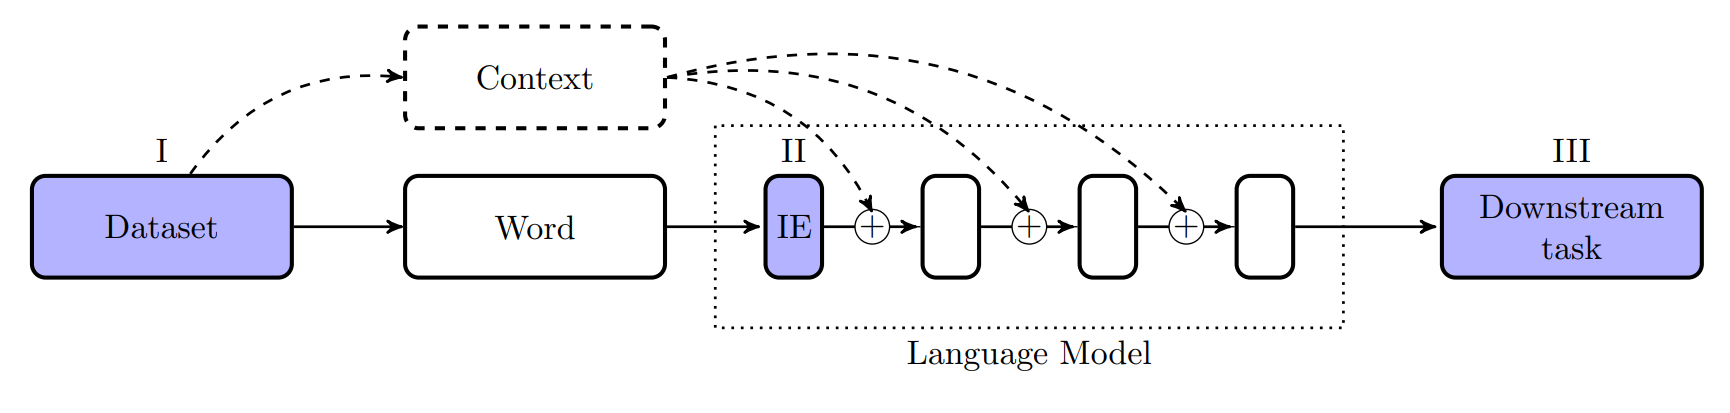

You will study the gender bias of four LSTM checkpoints taken during different points in training: after one batch (`batch_1.pt`), 11201 batches (`batch_11201.pt`), 1 epoch (`epoch_1.pt`), and 40 epochs (`epoch_40.pt`) of training. An epoch is defined as passing through all the data and is around 37,000 batches.

First, you will explore the gender bias in the Input Embeddings and the downstream task. Afterwards, you will use debiasing to investigate whether the two are causally related.

### Helper functions (please run code)

In [ ]:
import torch
import numpy as np

def wordlist2tensor(wordlist, model):
    """Converts wordlist to tensor, for use with allennlp"""
    tensor = torch.from_numpy(np.stack([model(x) for x in wordlist]))
    return tensor

#### LSTM Language Model

In [ ]:
import torch.nn as nn
import torch.utils.data.dataloader

class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder.
    ntoken: vocab size
    nip: embedding size
    """

    def __init__(
        self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False
    ):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ["LSTM", "GRU"]:
            self.rnn = getattr(nn, rnn_type)(
                ninp, nhid, nlayers, dropout=dropout, batch_first=True
            )
        else:
            try:
                nonlinearity = {"RNN_TANH": "tanh", "RNN_RELU": "relu"}[rnn_type]
            except KeyError:
                raise ValueError(
                    """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']"""
                )
            self.rnn = nn.RNN(
                ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout
            )
        self.decoder = nn.Linear(nhid, ntoken)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError(
                    "When using the tied flag, nhid must be equal to emsize"
                )
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden, output_vocab_probs=False):
        emb = self.encoder(input)
        output, hidden = self.rnn(emb, hidden)

        if output_vocab_probs:
            decoded = self.decoder(output)
            return decoded

        return output

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        if self.rnn_type == "LSTM":
            return (
                weight.new(self.nlayers, bsz, self.nhid).zero_(),
                weight.new(self.nlayers, bsz, self.nhid).zero_(),
            )
        else:
            return weight.new(self.nlayers, bsz, self.nhid).zero_()

In [ ]:
def simple_tokenizer(vocab, sentence):
    """Very basic tokenizer using space to split into tokens.
    Returns a torch.LongTensor with ids of the words according to the vocab.
    """
    return torch.LongTensor([[vocab[token] for token in sentence.split(" ")]])

class LSTMEmbedding():
    def __init__(self, model, vocab, device="cpu"):
        self.model = model
        self.vocab = vocab
        self.device = device

    def get_embedding_encoder(self, w):
        w_vec = (
            self.model.encoder(simple_tokenizer(self.vocab, w).to(self.device))
            .detach()
            .squeeze()
            .cpu()
            .numpy()
        )
        return w_vec

    def __call__(self, w):
        w_vec = self.get_embedding_encoder(w)
        return w_vec

In [ ]:
from collections import defaultdict

class LSTM():
    def __init__(self, model_fp, vocab, device="cuda"):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self._device = device
        self.unk_token="<unk>"
        self.pad_token = "<eos>"        
        self.load_model(model_fp, vocab)
        self.random = False
        self.embedding = None
        self.encoder = None
        

    @staticmethod
    def get_lstm(model_fp, vocab_fp, map_location="cpu"):
        lstm = RNNModel("LSTM", 50001, 650, 650, 2, tie_weights=True)
        try:
            lstm.load_state_dict(torch.load(model_fp, map_location=map_location))
        except:
            lstm.load_state_dict(
                torch.load(model_fp, map_location=map_location)["state_dict"]
            )

        lstm.eval()

        with open(vocab_fp, encoding="ISO-8859-2") as f:
            w2i = {w.strip(): i for i, w in enumerate(f)}

        vocab = defaultdict(lambda: w2i["<unk>"])
        vocab.update(w2i)
        return lstm, vocab

    def load_model(self, model, vocab):
        with open(vocab, encoding="ISO-8859-2") as f:
            self.w2i = {w.strip(): i for i, w in enumerate(f)}
        self.model, self.vocab = self.get_lstm(
            model, vocab, map_location=self._device
        )
        self.model = self.model.to(self.device)

    def get_embedding(self):
        if not self.embedding:
            self.embedding = LSTMEmbedding(
                self.model,
                self.vocab,
                device=self.device,
            )
        return self.embedding

    def get_language_model(self):
        if not self.encoder:
            self.encoder = LSTMEncoder(self.model, self.vocab, device=self.device)
        return self.encoder

In [ ]:
class LSTMEncoder:
    def __init__(self, lstm, vocab, device=None):
        self.lstm = lstm
        self.vocab = vocab
        self.device = device
        self.last_hidden_state = True
        self.numpy = True
        self.output_vocab_probs = False

    def __call__(self, template_sentences, X_lengths=None):
        # <eos> is token 20 in vocab
        pad_token = self.vocab["<eos>"]
        X = [simple_tokenizer(self.vocab, t) for t in template_sentences]
        X_lengths = [sentence.shape[1] for sentence in X]
        longest_sent = max(X_lengths)
        batch_size = len(X)

        padded_X = torch.ones((batch_size, longest_sent), dtype=torch.long) * pad_token

        for i, x_len in enumerate(X_lengths):
            sequence = X[i]
            padded_X[i, 0:x_len] = sequence[:x_len]

        if self.device:
            padded_X = padded_X.to(self.device)

        with torch.no_grad():
            hidden = self.lstm.init_hidden(batch_size)
            output = self.lstm(
                padded_X, hidden, output_vocab_probs=self.output_vocab_probs
            )

        # Only select last hidden state (ignoring <eos> padding)
        if self.last_hidden_state:
            idx = [x - 1 for x in X_lengths]
            last_hidden_state = output[torch.arange(output.size(0)), idx]
            result = last_hidden_state
        else:
            result = output

        return result.detach().cpu().numpy()

#### STS-B

In [ ]:
import numpy as np
import pandas as pd
import torch
from scipy import stats
from tqdm import tqdm

def cosine_similarity(A, B):
    dot = np.dot(A, B.T)
    norma = np.sqrt(np.dot(A, A.T))
    normb = np.sqrt(np.dot(B, B.T))
    cos = dot / (norma * normb)
    return cos

class TemplateDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, pair):
        self.dataframe = dataframe
        self.pair = pair  # e.g. pair1-1

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        return row["ID"], row[self.pair]


class STS_B:
    def __init__(
        self,
        sentence_encoder,
        templates_fp,
        occupation_fp,
    ):
        self.sentence_encoder = sentence_encoder

        self.df_templates = pd.read_csv(templates_fp, sep="\t")

        self.df_occupation_stats = pd.read_csv(occupation_fp, sep="\t").set_index(
            "occupation"
        )

        self.result_df = None
        self.result_df_ = None

        self.embeddings = {}
        self.prepare_embeddings()

    def prepare_embeddings(self):
      # TODO: Maybe save these embeddings to disk?
        for p in ["pair1-1", "pair1-2", "pair2-1", "pair2-2"]:
            dataset = TemplateDataset(self.df_templates, p)
            dataloader = torch.utils.data.DataLoader(
                dataset, batch_size=32, shuffle=False
            )
            for indices, sentences in tqdm(dataloader):
                embedding = self.get_last_hidden_state(sentences)
                for i, e in zip(indices, embedding):
                    self.embeddings[f"{i}-{p}"] = e

    def score_similarity(self, x):
        id = x["ID"]
        pair1_1 = self.embeddings[f"{id}-pair1-1"]
        pair1_2 = self.embeddings[f"{id}-pair1-2"]
        pair2_1 = self.embeddings[f"{id}-pair2-1"]
        pair2_2 = self.embeddings[f"{id}-pair2-2"]
        sim_pair1 = cosine_similarity(pair1_1, pair1_2)
        sim_pair2 = cosine_similarity(pair2_1, pair2_2)
        return {
            "similarity-pair1": sim_pair1,
            "similarity-pair2": sim_pair2,
            "difference-similarity": sim_pair2 - sim_pair1,
        }

    def get_correlation(self, method="pearson"):
        result_df = self.df_templates.apply(
            lambda x: self.score_similarity(x), axis=1, result_type="expand"
        )
        result_df["occupation"] = self.df_templates["occupation"]
        result_df["count_male"] = result_df["similarity-pair1"].ge(
            result_df["similarity-pair2"], axis=0
        )
        result_df = result_df.groupby(["occupation"]).agg(
            {
                "difference-similarity": "mean",
                "count_male": "sum",
                "similarity-pair1": "mean",
                "similarity-pair2": "mean",
            }
        )
        self.result_df_ = result_df.copy()
        self.result_df = result_df["difference-similarity"]

        return self.result_df.corr(
            self.df_occupation_stats["bls_pct_female"], method=method
        )

    def get_last_hidden_state(self, template_sentences):
        """sentence: string"""

        last_hidden_state = self.sentence_encoder(template_sentences)

        return last_hidden_state

    def __call__(self, method="pearson"):
        correlation = self.get_correlation(method=method)

        bias_df_occupations = self.result_df.to_frame()

        result_df_ = self.result_df_
        for v in ["count_male", "similarity-pair1", "similarity-pair2"]:
            bias_df_occupations[v] = result_df_[v]
        count_male = result_df_["count_male"].count()
        sim_pair1 = result_df_["similarity-pair1"].mean()
        sim_pair2 = result_df_["similarity-pair2"].mean()
        ratio = sim_pair2 / sim_pair1
        ratio_male = sim_pair1 / sim_pair2
        score = bias_df_occupations["difference-similarity"].abs().mean()

        bias_df = {
            "score": [score],
            "sim_male": [sim_pair1],
            "sim_female": [sim_pair2],
            "count_male": [count_male],
            "ratio": [ratio],
            "ratio_male": [ratio_male],
            "correlation": [correlation],
        }

        bias_df = pd.DataFrame.from_dict(bias_df)
        return (bias_df, bias_df_occupations)

### Gender Bias in Input Embeddings

The following lines load the input embeddings of the LSTM language model after training (epoch 40).

In [ ]:
lstm = LSTM("LSTM/epoch_40.pt", "LSTM/vocab.txt")
lstm_embedding = lstm.get_embedding()

FileNotFoundError: ignored

In [ ]:
lstm_embedding("man")

# New Section

Again, define the pairs of words for finding the gender subspace and the word list with occupation terms to test for bias.

In [ ]:
pairs = [('man', 'woman'),
 ('boy', 'girl'),
 ('male', 'female'),
 ('he', 'she'),
 ('himself', 'herself'),
 ('his', 'her'),
 ('father', 'mother'),
 ('son', 'daughter')]

In [ ]:
word_list = ['technician',
 'accountant',
 'supervisor',
 'engineer',
 'worker',
 'educator',
 'clerk',
 'counselor',
 'inspector',
 'mechanic',
 'manager',
 'therapist',
 'administrator',
 'receptionist',
 'librarian',
 'advisor',
 'pharmacist',
 'janitor',
 'psychologist',
 'physician',
 'carpenter',
 'nurse',
 'investigator',
 'bartender',
 'specialist',
 'electrician',
 'officer',
 'pathologist',
 'teacher',
 'lawyer',
 'planner',
 'practitioner',
 'plumber',
 'instructor',
 'surgeon',
 'veterinarian',
 'paramedic',
 'examiner',
 'chemist',
 'machinist',
 'architect',
 'hairdresser',
 'baker',
 'programmer',
 'scientist',
 'dispatcher',
 'cashier',
 'auditor',
 'painter',
 'broker',
 'chef',
 'doctor',
 'firefighter',
 'secretary']

Here is a function you can use for finding the gender bias for all the occupation terms. Notice that we now use the implementation from [the AllenNLP Fairness library](https://guide.allennlp.org/fairness#1) to find the **gender subspace**, $\vec{g}$.

In [ ]:
import allennlp.fairness

def get_input_embedding_bias(lstm_embedding, word_list, word_pairs):
    pairs_ = list(zip(*word_pairs))
    pair1_tensor = wordlist2tensor(pairs_[0], lstm_embedding)
    pair2_tensor = wordlist2tensor(pairs_[1], lstm_embedding)
    bias_dim = allennlp.fairness.bias_direction.ClassificationNormalBiasDirection()
    g = bias_dim(pair1_tensor, pair2_tensor).numpy()

    bias_df_occupations_IE = pd.DataFrame(columns=["word", "score", "type"])

    for w in word_list+list(chain.from_iterable(word_pairs)):
        bias_score = get_bias_score(lstm_embedding(w), g)
        bias_df_occupations_IE = bias_df_occupations_IE.append(
                      {
                          "word": w,
                          "score": bias_score,
                          "type": "occupation" if w in word_list else "gendered",
                      },
                      ignore_index=True,
                  )
    return bias_df_occupations_IE

bias_df_occupations_IE = get_input_embedding_bias(lstm_embedding, word_list, pairs)
bias_df_occupations_IE[bias_df_occupations_IE["type"]=="occupation"].sort_values("score")

It is possible to quickly check the validity (e.g. Does it intuitively make sense?) of the gender bias for the above occupation terms. Do you see how *nurse* and *receptionist* get a high female bias, while *scientist* and *engineer* get a high male bias?

Still, it would be nice to quantify the gender bias we find in some way. A popular approach in the literature is to compare the ranking of the bias scores with external (US) labour statistics with the % of male and female workers in that field.

In [ ]:
occupation_stats = pd.read_csv("https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/occupations-stats.tsv", sep="\t")[["occupation","bls_pct_female"]]
occupation_stats.sort_values("bls_pct_female")

#### ☑️ 2.1 ToDo
Correlate the ranking of occupations according to the Input Embedding bias (`bias_df_occupations_IE`) with the occupation statistics (`occupation_stats`). Use for example pandas' [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html). (Also note that some occupation terms might be missing from the LSTM's vocabulary, so leave these words out.)

How does it compare to the correlations of the LSTM earlier in training?

In [ ]:
def correlate_with_labour_statistics(bias_scores, method="pearson"):
    """Returns (pearson) correlation between the occupations ranked by 
    bias score and the labour statistics"""

    occupation_stats = pd.read_csv("https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/occupations-stats.tsv", sep="\t")[["occupation","bls_pct_female"]]

    raise NotImplementedError

    return correlation

In [ ]:
model_fp_list = ["LSTM/batch_1.pt", "LSTM/batch_11201.pt", "LSTM/epoch_1.pt", "LSTM/epoch_40.pt"]

for model_fp in model_fp_list:
    lstm = LSTM(model_fp, "LSTM/vocab.txt")
    lstm_embedding = lstm.get_embedding()
    bias = get_input_embedding_bias(lstm_embedding, word_list, pairs)
    print(model_fp, " correlation with labour statistics: ", correlate_with_labour_statistics(bias, method="pearson"))

### Gender Bias in Downstream Task
For testing the gender bias in a downstream task, we use the semantic textual similarity task for bias (**STS-B**, [Webster et al., 2021](https://arxiv.org/abs/2010.06032)). In this task, the LM is used for estimating the similarity of three sentences, containing either the word "man", "woman", or an occupation term. Then the gender bias for that occupation term is the  difference in the similarity averaged over a set of template sentences. 

💬 "This task contains 276 template sentences $t \in T$, where for each occupation $o$ that sentence either starts with that occupation, "man", or "woman", resulting in a triplet ($t(o)$, $t(“\text{man}”)$, $t(“\text{woman}”)$. 
One of the sentence triplets is, for example, *“A man/woman/janitor is playing the guitar”*. The gender bias for occupation $o$ is calculated as the average difference in similarity with the sentence starting with "man" compared to the sentence starting with "woman""

$$ \text{bias}_\text{STS-B}(o) = \frac{1}{T} \sum_{t\in T} \text{similarity}(t(o),t(“\text{man}”)) - \text{similarity}(t(o),t(“\text{woman}”)) $$

💬 "We use the cosine similarity of the last hidden states of our LSTM model as a proxy for the semantic similarity, to avoid training an additional semantic similarity classifier and making the relationship to the earlier stages of the language modelling pipeline less interpretable" (Van der Wal et al., 2022)

Below you see an example for finding the gender bias for "janitor" using one template sentence, where the final score is 0.75 - 0.54 = 0.21 (male bias).

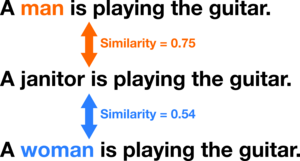

#### 🧠 2.2 ToThink ✍️
Give an advantage and a disadvantage for measuring gender bias in the Input Embeddings and in a downstream task? 

✍️ **ToSubmit 3**

A bulletpoint list with the advantages and disadvantages (one sentence each). Remember that researchers are ultimately interested in how users can be harmed by language technology.

Let's run the STS-B task for measuring the bias downstream (this can take a few minutes, make sure you have enabled the GPU in Colab!).

In [ ]:
lstm = LSTM("LSTM/epoch_40.pt", "LSTM/vocab.txt")
lstm_language_model = lstm.get_language_model()
stsb = STS_B(lstm_language_model,
        "data/sts-b.tsv",
        "data/occupations-stats.tsv",)

In [ ]:
(bias_df_STSB, bias_df_occupations_STSB) = stsb()
bias_df_occupations_STSB.sort_values(by="difference-similarity")

#### 🧠 2.3 ToThink
Would you call STS-B as it is explained above a downstream task? Why (not)?

### Debiasing Input Embeddings
💬 "So-far, our analyses have all been correlational.
In this section, we aim at establishing a causal
role for the representations of gender and gender
bias that we have described in the previous two
sections. We do so by intervening on the input
embeddings, using the debiasing method **Iterative
Null-space Projection** of [Ravfogel et al. (2020)](https://aclanthology.org/2020.acl-main.647/)."

💬 "In each debiasing step, a gender subspace is identified (as discussed in the previous section), after which all word vectors are projected on its null-space to remove this gender information. The authors show that performing a null-space projection once is not sufficient for removing bias completely. However, repeating this procedure multiple times turns out to be an effective mitigation strategy, without an overall decay of the embeddings [Ravfogel et al. (2020)](https://aclanthology.org/2020.acl-main.647/)." (Van der Wal et al., 2022)

In [ ]:
from allennlp.fairness.bias_mitigators import INLPBiasMitigator
import copy

def debias_lstm(lstm, pairs, num_iters=1):
    """Returns a debiased copy of the LSTM"""
    lstm = copy.deepcopy(lstm)
    pairs_ = list(zip(*pairs))
    pair1_tensor = wordlist2tensor(pairs_[0], lstm.get_embedding())
    pair2_tensor = wordlist2tensor(pairs_[1], lstm.get_embedding())
    debias = INLPBiasMitigator()
    debiased_weight = debias(
        lstm.model.encoder.weight,
        pair1_tensor.to(lstm.device),
        pair2_tensor.to(lstm.device),
        num_iters=num_iters,
    )
    lstm.model.encoder = torch.nn.Embedding.from_pretrained(debiased_weight)
    lstm.encoder = None
    lstm.embedding = None
    return lstm

#### 📊 2.5 ToShow ✍️
Debias the Input Embeddings of the LSTM and show the effect on the STS-B bias scores. Also show the effect on different groups (e.g. male and female gendered words) separately. Do you notice an asymmetry? Does this effect change with a different number of debiasing steps?

✍️ **ToSubmit 5**

Two bar-charts, one showing the sum of the absolute bias scores after 0-5 times debiasing and one showing these values for the two groups separately. Discuss the results in the caption (max 1/5 page). 

In [ ]:
debiased_lstm = debias_lstm(lstm, pairs, num_iters=3)
debiased_lstm_embedding = debiased_lstm.get_embedding()
get_input_embedding_bias(debiased_lstm_embedding, word_list, pairs)

raise NotImplementedError

## 3 Gender Bias in BERT using Challenge Sets
Challenge sets are carefully created datasets used for probing a language model on certain behaviour (the STS-B task you saw earlier is an example of a challenge set). Measuring the biased behaviour at the output of the model (e.g. language modelling), it is more clear how it could lead to actual harms to people ([Blodgett et al., 2020](https://aclanthology.org/2020.acl-main.485/)). You will briefly explore one such challenge set.

**CrowS-Pairs** ([Nangia et al., 2020](https://arxiv.org/pdf/2010.00133.pdf)) is a challenge set for testing whether a masked language model (e.g. BERT) is biased towards stereotypes (e.g. gender, race, nationality). It consists of sentence pairs, where the language model is used for scoring the more stereotypical (`sent_more`) and less stereotypical example (`sent_less`). They aggregate how often `sent_more` is preferred to get an indication of how biased the LM is towards stereotypes.

In the paper, they explain how they score the sentences to avoid problems with divergent word frequencies:

💬 "In an example there are two parts of
each sentence: the **unmodified** part, which comprises of the tokens that overlap between the two
sentences in a pair, and the **modified part**, which
are the non-overlapping tokens. For example, for a
pair *John ran into his old football friend* vs. *Shaniqua ran into her old football friend*, the modified
tokens are {*John*, *his*} for the first sentence and
{*Shaniqua*, *her*} for the second sentence."

💬 "Within an example, it is
possible that the modified tokens in one sentence
occur more frequently in the MLM’s pretraining
data. For example, *John* may be more frequent
than *Shaniqua*. We want to control for this imbalance in frequency, and to do so we condition on the
modified tokens when estimating the likelihoods
of the unmodified tokens."

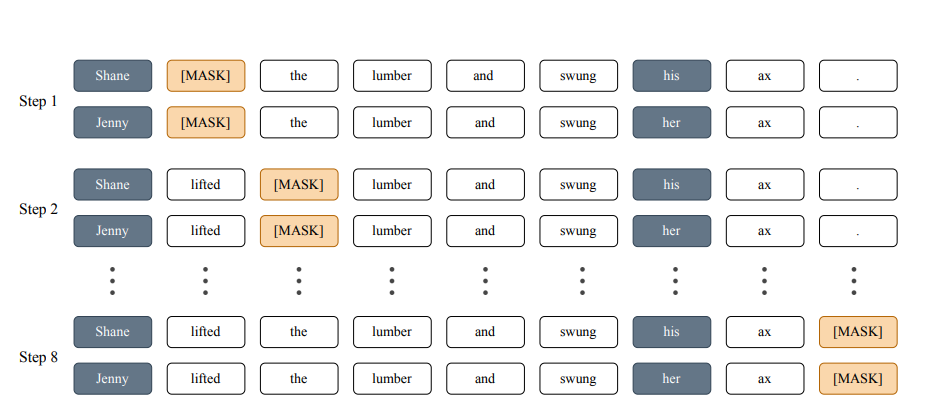

💬 Figure from [Nangia et al., (2020)](https://arxiv.org/pdf/2010.00133.pdf): "To calculate the conditional pseudo-log-likelihood of each sentence, we iterate over the sentence, masking a single token at a time, measuring its log likelihood, and accumulating the result in a sum (Salazar et al., 2020).
We never mask the modified tokens: those that differ between the two sentences, shown in grey."

#### 🧠 3.1 ToThink
CrowS-Pairs is originally developed for masked language modelling. How can we use the dataset for measuring the bias in autoregressive language models (e.g. GPT-3)? Do you think we can then make a fair comparison between the bias of a masked LM and an autoregressive? Why (not)?

In [ ]:
!pip install datasets

### CrowS-Pairs
[Blodgett et al. (2021)](https://www.microsoft.com/en-us/research/uploads/prod/2021/06/The_Salmon_paper.pdf) investigated the quality and validity of the CrowS-Pairs dataset, and found many examples of sentence pairs that do not make sense for measuring the bias.

In the figure below, the example for measuring stereotypes of Norwegians, mentions the context sentence "I really like Norweigan salmon". Obviously, we would not associate Norwegian salmon too much with (Norwegian) exchange students and how well they do in either art and drama or football. Also note the misspelling of Norwegian, which could invalidate it even more if the LM doesn't link that to the right spelling of the word.

If the bias dataset has too much noise and bad examples, we should question the validity of the dataset. Does it really measure the bias towards stereotypes in LMs, or is it something else?

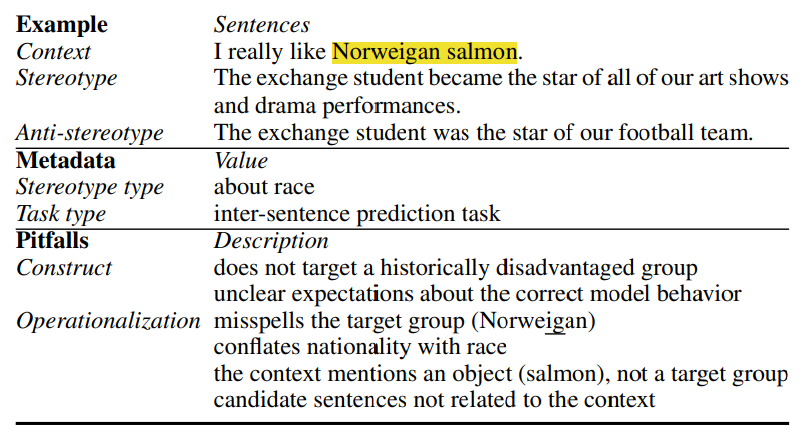

In [ ]:
from datasets import load_dataset
dataset = load_dataset("crows_pairs")
dataset["test"].to_pandas()

Another downside of CrowS-Pairs is that the examples are designed with a North American cultural context in mind. Many of these examples would not make sense in, say, a Dutch or other European context. [Talat et al., (2022)](https://aclanthology.org/2022.bigscience-1.3.pdf) argue the importance of creating "culturally aware" datasets that go beyond the Anglo-centric context if we want to evaluate LMs for different cultures and languages. In this light, some researchers have already adapted CrowS-Pairs to French ([Névéol et al., 2022](https://hal.inria.fr/hal-03629677/document)).

#### 📊 3.2 ToShow ✍️
Explore the CrowS-Pairs dataset and show three examples of a sentence pair that would not be valid for testing a similar bias type outside of a North American context (for different reasons). Explain why you believe the examples are not good for showing the bias in a different cultural context.

✍️ **ToSubmit 6**

Three screenshots of the sentence pairs each with a caption (max 1/5 page) explaining why you chose this example.

*TIP: You can click on the blue magic wand in the dataframe above to make it easier to explore the dataset. If Colab crashses, try it using no GPUs as backend.*

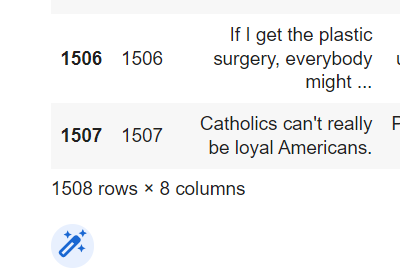

## 4 Future work


The rest of this project consists of your own experiment where you test one of three bias measures on how well it performs: 

1.   WEAT ([Caliskan et al., 2017](https://www.science.org/doi/full/10.1126/science.aal4230?casa_token=PY9LAMLJHFoAAAAA%3AoapE0jEx3L1LrhyY-1tt7B_udyh0j4qUSbRX87_uUMMyPiatBTTlOcu0ogQjmGzthh_tQWrFqEBhO7k));
2.   Bias Direction (e.g., Bolukbasi et al., 2016; see [see e.g. this AllenNLP guide](https://guide.allennlp.org/fairness#3)); and
3.   CrowS-Pairs ([Nangia et al., 2020](https://aclanthology.org/2020.emnlp-main.154/); [Névéol et al., 2022](https://aclanthology.org/2022.acl-long.583/)).

The first two are for static word embeddings (e.g., word2vec, glove, fasttext), while CrowS-Pairs is designed for a language model (originally BERT, but it can be adapted to suit e.g. GPT-2 when using perplexity to compare sentences).

**You will implement this bias measure and then assess its [validity and reliability](https://www.scribbr.com/methodology/reliability-vs-validity/)**. More information on the concepts of validity and reliability can be found in Sections 3 and 4 of [📄 "Undesirable biases in NLP: Averting a crisis of measurement"](https://arxiv.org/abs/2211.13709).

### 🧠 4.1 ToThink


Given your choice of the bias measure, make sure you are clear on the following things when describing it in your method section:
- The model (representation) you want to measure the bias in;
- The bias type you want to investigate (e.g., (non-)binary gender bias);
- The cultural context that you consider (e.g., English);
- The operationalization of the bias (i.e., how is bias defined and how do you measure it).

### 🧠 4.2 ToThink

An important part of your project will be to test the **reliability** (*how consistent and precise is the bias measure?*) and **validity** (*am I measuring the construct of interest or actually something else?*) of your bias measure. For instance, we can have a bias measure that does give us information on the gender bias, but is very noisy. On the other hand, it can also be that our bias measure is very reliable, but is actually measuring something different (e.g., instead of gender bias of words, their sentiment or frequency).

There are many strategies to achieve this, and what is most suitable for testing the reliability and validity depends on factors such as the choice of model, bias type, operationalization, as well as what other bias measures are available (which you could use for testing the [*convergent validity*](https://www.scribbr.com/methodology/convergent-validity)). For example, can you train/finetune your own model with different seeds to test *test-retest reliability*? Or can you train a new model on a biased/debiased dataset to test whether your measure reflects these differences (higher/lower bias score) to test the validity?

In the first week, we will discuss some ways you could test the reliability and validity of the three bias measure mentioned above. You can also check Section 5.1 in ["Undesirable biases in NLP: Averting a crisis of measurement"](https://arxiv.org/abs/2211.13709) for some additional tips on how to approach this.